In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

BASEPATH = os.environ["BASEPATH"]



In [2]:
from glob import glob
import tomllib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.plotting import convert_size
from src.utils.load_and_save import load_articles_from_hdf5



sns.set_context("paper")

In [3]:
def parse_directories():
    """
    Parse the directories from the configuration file.
    Returns:
    - directories: dict
    """
    with open('../config/directories.toml', 'rb') as f:
        configurations = tomllib.load(f)

    return configurations

def get_citations_per_year(article, df):
    citing_articles = article.in_links

    publication_years = [df[df['Pmid'] == citing_article]['Year'].values[0] - article.year for citing_article in citing_articles]

    counts = pd.Series(publication_years).value_counts().sort_index()
    return counts

In [4]:
directories = parse_directories()
csv_path = os.path.join(BASEPATH, directories['public']['csv'])
article_file = os.path.join(csv_path, "neuroscience_articles_1999-2023.csv")
article_df = pd.read_csv(article_file)

shard_folder = os.path.join(BASEPATH, directories['public']['hdf5'])
shard_files = glob(os.path.join(shard_folder, '*.h5'))

figure_path = os.path.join(BASEPATH, directories['internal']['manuscript']['figures'], 'Figure_01')
os.makedirs(figure_path, exist_ok=True)

In [5]:
journal_replacements = dict()
unique_journals = article_df["Journal"].unique()
for journal in unique_journals:
    if ' : ' in journal:
        journal_replacements[journal] = journal.split(' : ')[0]
    elif '(' in journal:
        journal_replacements[journal] = journal.split(' (')[0]

journal_replacements['Proceedings of the National Academy of Sciences of the United States of America'] = 'PNAS'
journal_replacements['Proceedings of the Japan Academy. Series B, Physical and biological sciences'] = 'PJA Series B'

# Replace journal names using the dictionary
article_df["Journal"] = article_df["Journal"].replace(journal_replacements)

### Figure 1 Panels

In [ ]:
# Define the panel size (width, height) in centimeters
figure_size = [89, 89]
figure_size_half_height = [89, 44.5]
inset_size = [30, 30]

# Convert the panel size to inches
figure_size_inch = convert_size(*figure_size)
figure_size_half_height_inch = convert_size(*figure_size_half_height)
inset_size_inch = convert_size(*inset_size)

# Define the color palette
colors = ['#fe6100', '#785ef0']

# Define hue order
hue_order = ['Review', 'Research']

# Define the font sizes
fontsize_text = 6
fontsize_ticks = 5

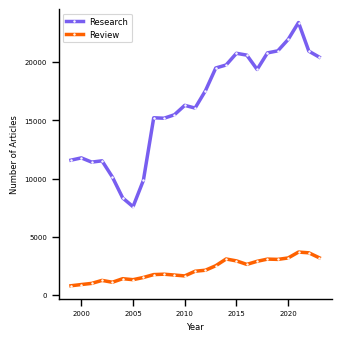

In [7]:
# Panel A main: Line plot of the number of articles published per year separated by article type

# Count the occurrences of each article type per year
counts = article_df.groupby(['Year', 'Type']).size().unstack().fillna(0)

# Create the line plot
plt.figure(figsize=figure_size_inch)
sns.lineplot(data=counts, palette=colors, linewidth=2.5, dashes=False, markers=True)
plt.setp(plt.gca().get_lines(), marker='o', markersize=1)
sns.despine()
plt.xlabel('Year', fontsize=fontsize_text)
plt.ylabel('Number of Articles', fontsize=fontsize_text)
plt.legend(title=None, fontsize=fontsize_text)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_a_main.svg'), format='svg')
plt.show()


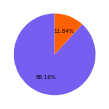

In [8]:
# Panel A inset: Pie chart of the distribution of article types

# Count the occurrences of each article type
type_counts = article_df['Type'].value_counts()

# Create the pie chart
plt.figure(figsize=inset_size_inch)

plt.pie(type_counts, labels=None, colors=colors, autopct='%1.2f%%', startangle=90, textprops={'fontsize': 4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()

plt.savefig(os.path.join(figure_path, 'panel_a_inset.svg'), format='svg')
plt.show()

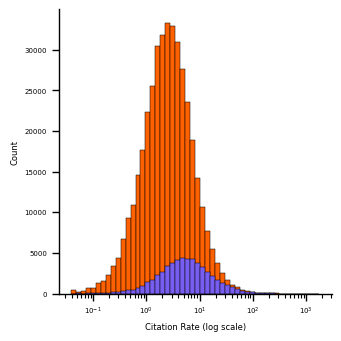

In [9]:
# Panel B: Histogram of citation rates separated by article type (frequency in log scale instead of count)

plt.figure(figsize=figure_size_inch)
sns.histplot(data=article_df, x='Citation Rate', hue='Type', hue_order=hue_order,  palette=colors, log_scale=True, bins=50, alpha=1)
sns.despine()
plt.xlabel('Citation Rate (log scale)', fontsize=fontsize_text)
plt.ylabel('Count', fontsize=fontsize_text)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_b.svg'), format='svg')
plt.show()

In [10]:
research_df = article_df[article_df['Type'] == 'Research']
review_df = article_df[article_df['Type'] == 'Review']

print('Research Articles')
print(research_df['Citation Rate'].describe())

print('Review Articles')
print(review_df['Citation Rate'].describe())

Research Articles
count    406710.000000
mean          4.471175
std           9.458161
min           0.000000
25%           1.183359
50%           2.480134
75%           4.952105
max        1765.173427
Name: Citation Rate, dtype: float64
Review Articles
count    54606.000000
mean         9.983088
std         17.102528
min          0.000000
25%          2.531970
50%          5.263526
75%         10.817481
max        556.081447
Name: Citation Rate, dtype: float64


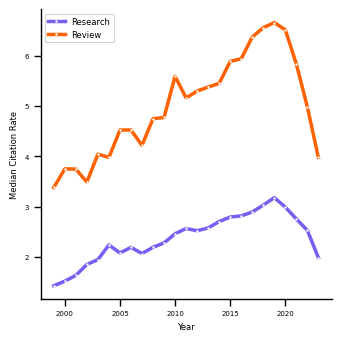

In [11]:
# Panel C: Line plot of median citation rates per year separated by article type
colors = ['#785ef0', '#fe6100']

# Set font sizes
fontsize_label = 6
fontsize_ticks = 5

# Define the panel size (width, height) in centimeters
figure_size = [89, 89]

# Convert the panel size to inches
figure_size_inch = convert_size(*figure_size)

# Calculate the median citation rate per year and article type
medians = article_df.groupby(['Year', 'Type'])['Citation Rate'].median().unstack()

# Create the line plot
plt.figure(figsize=figure_size_inch)
sns.lineplot(data=medians, palette=colors, linewidth=2.5, dashes=False, markers=True)
plt.setp(plt.gca().get_lines(), marker='o', markersize=1)
sns.despine()
plt.xlabel('Year', fontsize=fontsize_label)
plt.ylabel('Median Citation Rate', fontsize=fontsize_label)
plt.legend(title=None, fontsize=fontsize_label)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_c.svg'), format='svg')
plt.show()

#### Panel D - Research articles

In [12]:
total_articles = 10000
cutoff_year = 2019
articles_of_interest = []

pubmed_ids_of_interest = article_df[(article_df['Year'] < cutoff_year) & (article_df['Type'] == 'Research')]['Pmid'].values
for shard_file in shard_files:
    articles = load_articles_from_hdf5(shard_file, disable_tqdm=True)
    articles_of_interest.extend([article for article in articles if article.pmid in pubmed_ids_of_interest])

    if len(articles_of_interest) >= total_articles:
        break

articles_of_interest = articles_of_interest[:total_articles]

In [13]:
citations_per_year = [get_citations_per_year(article, article_df) for article in articles_of_interest]
citations_per_year = pd.concat(citations_per_year, axis=1).fillna(0).T
citations_per_year = citations_per_year.sort_index(axis=1)
citations_per_year = citations_per_year.loc[:, (citations_per_year.columns >= 0)]

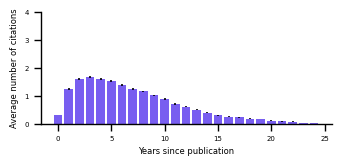

In [14]:
sns.set_context("paper")
plt.figure(figsize=figure_size_half_height_inch)
# plot the median citations per year with error bars based on percentiles (95% confidence interval)
plt.bar(citations_per_year.columns, citations_per_year.mean(axis=0), yerr=citations_per_year.sem(axis=0), color=colors[0])
sns.despine()
plt.xlabel('Years since publication', fontsize=fontsize_text)
plt.ylabel('Average number of citations', fontsize=fontsize_text)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.ylim(0, 4)
plt.tight_layout()

plt.savefig(os.path.join(figure_path, 'panel_d_research.svg'), format='svg')
plt.show()

#### Panel D - Review articles

In [15]:
total_articles = 10000
cutoff_year = 2019
articles_of_interest = []

pubmed_ids_of_interest = article_df[(article_df['Year'] < cutoff_year) & (article_df['Type'] == 'Review')]['Pmid'].values
for shard_file in shard_files:
    articles = load_articles_from_hdf5(shard_file, disable_tqdm=True)
    articles_of_interest.extend([article for article in articles if article.pmid in pubmed_ids_of_interest])

    if len(articles_of_interest) >= total_articles:
        break

articles_of_interest = articles_of_interest[:total_articles]

In [16]:
citations_per_year = [get_citations_per_year(article, article_df) for article in articles_of_interest]
citations_per_year = pd.concat(citations_per_year, axis=1).fillna(0).T
citations_per_year = citations_per_year.sort_index(axis=1)
citations_per_year = citations_per_year.loc[:, (citations_per_year.columns >= 0)]

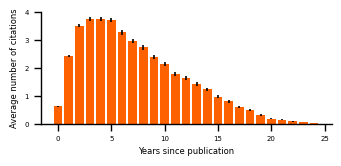

In [17]:
sns.set_context("paper")
plt.figure(figsize=figure_size_half_height_inch)
# plot the median citations per year with error bars based on percentiles (95% confidence interval)
plt.bar(citations_per_year.columns, citations_per_year.mean(axis=0), yerr=citations_per_year.sem(axis=0), color=colors[1])
sns.despine()
plt.xlabel('Years since publication', fontsize=fontsize_text)
plt.ylabel('Average number of citations', fontsize=fontsize_text)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.ylim(0, 4)
plt.tight_layout()

plt.savefig(os.path.join(figure_path, 'panel_d_review.svg'), format='svg')
plt.show()

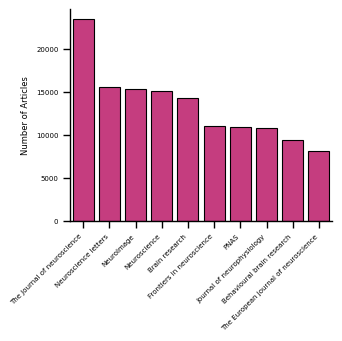

In [18]:
# Panel E: Bar plot of the top 10 journals by number of articles

journal_counts = article_df['Journal'].value_counts()
top_journals = journal_counts.head(10)
plt.figure(figsize=figure_size_inch)
#top_journals.plot(kind='bar', color='#dc267f', edgecolor='black')
sns.barplot(x=top_journals.index, y=top_journals.values, color='#dc267f', edgecolor='black')
sns.despine()
plt.xlabel('')
plt.ylabel('Number of Articles', fontsize=fontsize_text)
plt.xticks(rotation=45, ha='right', fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_e.svg'), format='svg')
plt.show()


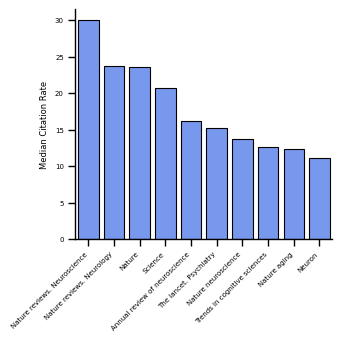

In [19]:
# Panel F: Bar plot of the top 10 journals by median citation rate

journal_citation_df = article_df.groupby('Journal')['Citation Rate'].median().reset_index()
top_journals_citations = journal_citation_df.sort_values('Citation Rate', ascending=False).head(10)
plt.figure(figsize=figure_size_inch)
sns.barplot(data=top_journals_citations, x='Journal', y='Citation Rate', color='#648fff', edgecolor='black')
sns.despine()
plt.xlabel('')
plt.ylabel('Median Citation Rate', fontsize=fontsize_text)
plt.xticks(rotation=45, ha='right', fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'panel_f.svg'), format='svg')
plt.show()
